In [3]:
print("Before running this file, please run Data_Preparation.ipynb")

Before running this file, please run Data_Preparation.ipynb


In [4]:
import azureml.core
import pandas as pd
import numpy as np
import logging

print("Azure SDK Version: ", azureml.core.VERSION)

Azure SDK Version:  1.38.0


In [5]:
from azureml.core import Workspace, Experiment

ws = Workspace.from_config()

experiment_name = "automl_loan_approval_prediction"

experiment =  Experiment(ws, experiment_name)

output={}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth',-1)
outputDf = pd.DataFrame(data=output,index=[''])
outputDf.T

,
Subscription ID,8c96f3ed-e53f-4400-a002-420605371b18
Workspace,FRT_Project
Resource Group,Azure_Project
Location,westus
Experiment Name,automl_loan_approval_prediction


In [12]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

cpu_cluster_name = "cpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws,name=cpu_cluster_name)
    print("Found existing cluster, use it. ")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2", max_nodes = 6)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [13]:
datastore = ws.get_default_datastore() 
datastore.upload_files(files = ['Prepared_train.csv'], target_path='dataset/', overwrite=True, show_progress=True)

Uploading an estimated of 1 files
Uploading Prepared_train.csv
Uploaded Prepared_train.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_2624d8f1af8440edb28c6900da718124

In [14]:
from azureml.core import Dataset

dataset = Dataset.Tabular.from_delimited_files(path=[(datastore,'dataset/Prepared_train.csv')])
df = dataset.to_pandas_dataframe().reset_index(drop=True)

df.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,10000,32236,12329.36286,59,2522922,11.135007,2,34,0,176346.62670,...,0.102055,2.498291,0.793724,0,0,49,31,311301,6619,0
1,3609,11940,12191.99692,59,1586599,12.237563,3,43,1,39833.92100,...,0.036181,2.377215,0.974821,0,0,109,53,182610,20885,0
2,28276,9311,21603.22455,59,2136391,12.545884,6,44,0,91506.69105,...,18.778660,4.316277,1.020075,0,0,66,34,89801,26155,0
3,11170,6954,17877.15585,59,2428731,16.731201,3,33,0,108286.57590,...,0.044131,0.107020,0.749971,0,0,39,40,9189,60214,0
4,16890,13226,13539.92667,59,5341619,15.008300,3,44,0,44234.82545,...,19.306646,1294.818751,0.368953,0,0,18,430,126029,22579,0


In [15]:
training_data, validation_data = dataset.random_split(percentage=0.9, seed=223)

In [16]:
from azureml.train.automl import AutoMLConfig

automl_settings = {
    "experiment_timeout_hours":4.0,
    "enable_early_stopping": True,
    "iteration_timeout_minutes":10,
    "max_concurrent_iterations":4,
    "max_cores_per_iteration":-1,
    "n_cross_validations":3,
    "primary_metric": 'AUC_weighted',
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task='classification',
                             debug_log='automated_ml_errors.log',
                             training_data= training_data,
                             label_column_name='Loan Status',
                             **automl_settings)

In [17]:
remote_run = experiment.submit(automl_config, show_output=False)
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl_loan_approval_prediction,AutoML_9301b394-5cc4-49a7-beee-c3f879f52408,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


INFO:interpret_community.common.explanation_utils:Using default datastore for uploads


Experiment,Id,Type,Status,Details Page,Docs Page
automl_loan_approval_prediction,AutoML_9301b394-5cc4-49a7-beee-c3f879f52408,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [18]:
from azureml.widgets import RunDetails

RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [19]:
remote_run.wait_for_completion()

{'runId': 'AutoML_9301b394-5cc4-49a7-beee-c3f879f52408',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2022-02-02T17:27:39.507389Z',
 'endTimeUtc': '2022-02-02T18:39:29.690111Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'No scores improved over last 20 iterations, so experiment stopped early. This early stopping behavior can be disabled by setting enable_early_stopping = False in AutoMLConfig for notebook/python SDK runs.'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'local',
  'AMLSettingsJsonString': '{"path":null,"name":"automl_loan_approval_prediction","subscription_id":"8c96f3ed-e53f-4400-a002-420605371b18","resource_group":"Azure_Project","workspace_name":"FRT_Project","region":"westus","compute_target":"local","spark_service":null,"azure

In [20]:
best_run, fitted_model = remote_run.get_output()
fitted_model

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='f:\\Work\\Azure_Project')),
                ('MaxAbsSc...
                 LightGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7922222222222222, learning_rate=0.04737368421052632, max_bin=380, max_depth=4, min_child_weight=8, min_data_in_leaf=0.03793724137931035, min_split_gain=0.3684210526315789, n_estimators=400, n_jobs=-1, num_leaves=224, problem_info=ProblemInfo(
    gpu_training_param_dict={'processing_unit_type': 'cpu'}
), random_state=None, reg_alpha=0, reg_lambda=0.6842105263157894, subsample=0.14894736842105263))],
         verbose=False)

In [21]:
fitted_model.named_steps['datatransformer'].get_engineered_feature_names()

['Application Type_ModeCatImputer_LabelEncoder',
 'Batch Enrolled_CharGramCountVectorizer_1104812',
 'Batch Enrolled_CharGramCountVectorizer_1135695',
 'Batch Enrolled_CharGramCountVectorizer_1184694',
 'Batch Enrolled_CharGramCountVectorizer_1467036',
 'Batch Enrolled_CharGramCountVectorizer_1586599',
 'Batch Enrolled_CharGramCountVectorizer_1761981',
 'Batch Enrolled_CharGramCountVectorizer_1766061',
 'Batch Enrolled_CharGramCountVectorizer_1780517',
 'Batch Enrolled_CharGramCountVectorizer_1930365',
 'Batch Enrolled_CharGramCountVectorizer_2003848',
 'Batch Enrolled_CharGramCountVectorizer_2078974',
 'Batch Enrolled_CharGramCountVectorizer_2136391',
 'Batch Enrolled_CharGramCountVectorizer_224923',
 'Batch Enrolled_CharGramCountVectorizer_2252229',
 'Batch Enrolled_CharGramCountVectorizer_2333412',
 'Batch Enrolled_CharGramCountVectorizer_2428731',
 'Batch Enrolled_CharGramCountVectorizer_2522922',
 'Batch Enrolled_CharGramCountVectorizer_2558388',
 'Batch Enrolled_CharGramCountVect

In [22]:
featurization_summay = fitted_model.named_steps['datatransformer'].get_featurization_summary()
pd.DataFrame.from_records(featurization_summay)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Application Type,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]
1,Batch Enrolled,Categorical,No,41,[StringCast-CharGramCountVectorizer]
2,Collection 12 months Medical,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]
3,Delinquency - two years,Categorical,No,9,[StringCast-CharGramCountVectorizer]
4,Employment Duration,Categorical,No,3,[StringCast-CharGramCountVectorizer]
5,Grade,Categorical,No,7,[StringCast-CharGramCountVectorizer]
6,Initial List Status,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]
7,Inquires - six months,Categorical,No,6,[StringCast-CharGramCountVectorizer]
8,Open Account,Categorical,No,36,[StringCast-CharGramCountVectorizer]
9,Public Record,Categorical,No,5,[StringCast-CharGramCountVectorizer]


In [23]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(
    columns=['Loan Status']
).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(
    columns=['Loan Status'], validate=True
).to_pandas_dataframe()

In [24]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_df.values,y_pred)
print("Accuracy Score of the model: ",accuracy)

Accuracy Score of the model:  0.9042443824350125


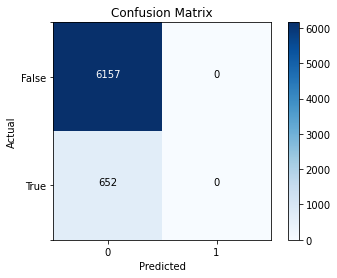

In [31]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import numpy as np
import itertools

cf = confusion_matrix(y_test_df.values, y_pred)
plt.imshow(cf, cmap=plt.cm.Blues, interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
class_labels = ["False", "True"]
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks([-0.5, 0, 1, 1.5], ["", "False", "True", ""])
# plotting text value inside cells
thresh = cf.max() / 2.0
for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    plt.text(
        j,
        i,
        format(cf[i, j], "d"),
        horizontalalignment="center",
        color="white" if cf[i, j] > thresh else "black",
    )
plt.show()

In [141]:
# Retrieve the best Run object
best_run = remote_run.get_best_child()

In [142]:
import json
# Download the featurization summary JSON file locally
best_run.download_file(
    "outputs/featurization_summary.json", "featurization_summary.json"
)

# Render the JSON as a pandas DataFrame
with open("featurization_summary.json", "r") as f:
    records = json.load(f)

featurization_summary = pd.DataFrame.from_records(records)
featurization_summary["Transformations"].tolist()

[['ModeCatImputer-StringCast-LabelEncoder'],
 ['StringCast-CharGramCountVectorizer'],
 ['ModeCatImputer-StringCast-LabelEncoder'],
 ['StringCast-CharGramCountVectorizer'],
 ['StringCast-CharGramCountVectorizer'],
 ['StringCast-CharGramCountVectorizer'],
 ['ModeCatImputer-StringCast-LabelEncoder'],
 ['StringCast-CharGramCountVectorizer'],
 ['StringCast-CharGramCountVectorizer'],
 ['StringCast-CharGramCountVectorizer'],
 ['StringCast-CharGramCountVectorizer'],
 ['StringCast-CharGramCountVectorizer'],
 ['StringCast-CharGramCountVectorizer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer'],
 ['MeanImputer']]

In [143]:
from helper import run_inference, get_result_df
from azureml.core.run import Run
summary_df = get_result_df(remote_run)
best_dnn_run_id = summary_df["run_id"].iloc[0]
best_dnn_run = Run(experiment, best_dnn_run_id)

In [144]:
from azureml.interpret import ExplanationClient
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

INFO:interpret_community.common.explanation_utils:Using default datastore for uploads


{'Total Collection Amount_MeanImputer': 0.07648121196387409,
 'Term_CharGramCountVectorizer_58': 0.06383197856629155,
 'Collection Recovery Fee_MeanImputer': 0.05282955128848845,
 'Total Accounts_MeanImputer': 0.034079023085002616,
 'Employment Duration_CharGramCountVectorizer_0': 0.03259965160457107,
 'Total Received Late Fee_MeanImputer': 0.03191473501084951,
 'Revolving Balance_MeanImputer': 0.03001642580334405,
 'Loan Amount_MeanImputer': 0.026978641842226887,
 'Initial List Status_ModeCatImputer_LabelEncoder': 0.026757795108141552,
 'Total Current Balance_MeanImputer': 0.023589254599611753,
 'Home Ownership_MeanImputer': 0.023507020464357403,
 'Recoveries_MeanImputer': 0.022535194918242848,
 'Funded Amount Investor_MeanImputer': 0.022433531384152515,
 'Total Revolving Credit Limit_MeanImputer': 0.02088930157703165,
 'Revolving Utilities_MeanImputer': 0.02011809324006775,
 'Debit to Income_MeanImputer': 0.019047266110953864,
 'Grade_CharGramCountVectorizer_2': 0.017548898829533883,

In [145]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=True)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

INFO:interpret_community.common.explanation_utils:Using default datastore for uploads


{'Total Collection Amount': 0.07648121196387409,
 'Term': 0.06717117032965636,
 'Collection Recovery Fee': 0.05282955128848845,
 'Total Accounts': 0.034079023085002616,
 'Employment Duration': 0.03259965160457107,
 'Total Received Late Fee': 0.03191473501084951,
 'Revolving Balance': 0.03001642580334405,
 'Loan Amount': 0.026978641842226887,
 'Initial List Status': 0.026757795108141552,
 'Total Current Balance': 0.023589254599611753,
 'Home Ownership': 0.023507020464357403,
 'Sub Grade': 0.023015017549006044,
 'Recoveries': 0.022535194918242848,
 'Funded Amount Investor': 0.022433531384152515,
 'Total Revolving Credit Limit': 0.02088930157703165,
 'Revolving Utilities': 0.02011809324006775,
 'Debit to Income': 0.019047266110953864,
 'Grade': 0.017548898829533883,
 'Last week Pay': 0.017380961881899967,
 'Funded Amount': 0.012778864064291174,
 'Open Account': 0.011499027760350115,
 'Total Received Interest': 0.009558843576625132,
 'Interest Rate': 0.009490633853031024,
 'Batch Enrolled'

In [146]:
import os
model_dir = "Model"  # Local folder where the model will be stored temporarily
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

best_dnn_run.download_file("outputs/model.pkl", model_dir + "/model.pkl")

In [147]:
model_name = best_run.properties["model_name"]

script_file_name = "inference/score.py"

best_run.download_file("outputs/scoring_file_v_1_0_0.py", "inference/score.py")

In [148]:
best_run.download_file("outputs/model.pkl", model_dir + "/Best_model.pkl")
# Register model
model_Final = Model.register(ws, model_name=model_name, model_path= model_dir+"/Best_model.pkl")

Registering model AutoML9301b394516


In [149]:
description = "AutoML Model trained on bank data to predict whether to give out loan or not to a perticular person or entity."
tags = None
model = remote_run.register_model(
    model_name=model_name, description=description, tags=tags
)

print(
    remote_run.model_id
)  # This will be written to the script file later in the notebook.

AutoML9301b394516


In [150]:
from azureml.core.environment import Environment
from azureml.automl.core.shared import constants
from azureml.core.model import InferenceConfig
best_run.download_file(constants.CONDA_ENV_FILE_PATH, 'myenv.yml')
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="inference/score.py", environment=myenv)

In [152]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1,
    memory_gb=1,
    tags={"area": "bmData", "type": "automl_classification"},
    description="sample service for Automl Classification",
)

aci_service_name = model_name.lower()
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl9301b394516
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-02-03 21:34:45+05:30 Creating Container Registry if not exists.
2022-02-03 21:34:46+05:30 Registering the environment.
2022-02-03 21:34:46+05:30 Use the existing image.
2022-02-03 21:34:46+05:30 Generating deployment configuration.
2022-02-03 21:34:47+05:30 Submitting deployment to compute.
2022-02-03 21:34:52+05:30 Checking the status of deployment automl9301b394516..
2022-02-03 21:39:28+05:30 Checking the status of inference endpoint automl9301b394516.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [153]:
from numpy import array
test_dataset = validation_data
test_dataset.take(3).to_pandas_dataframe()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,11170,6954,17877.16,59,2428731,16.73,3,33,0,108286.58,...,0.04,0.11,0.75,0,0,39,40,9189,60214,0
1,8640,6428,8169.78,59,2252229,8.63,2,15,1,41858.89,...,0.04,3.50,0.77,0,0,34,26,141492,18025,0
2,34653,18985,4917.13,58,4694572,10.59,6,21,0,60883.56,...,0.07,4.48,0.39,0,0,72,1572,304173,28826,0


In [154]:
X_test = test_dataset.drop_columns(columns=["Loan Status"])
y_test = test_dataset.keep_columns(columns=["Loan Status"], validate=True)
test_dataset.take(5).to_pandas_dataframe()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,11170,6954,17877.16,59,2428731,16.73,3,33,0,108286.58,...,0.04,0.11,0.75,0,0,39,40,9189,60214,0
1,8640,6428,8169.78,59,2252229,8.63,2,15,1,41858.89,...,0.04,3.50,0.77,0,0,34,26,141492,18025,0
2,34653,18985,4917.13,58,4694572,10.59,6,21,0,60883.56,...,0.07,4.48,0.39,0,0,72,1572,304173,28826,0
3,16642,9400,10727.56,58,5525466,11.18,2,14,0,67166.67,...,0.06,5.61,0.20,0,0,66,16,128988,15802,0
4,6373,12341,10452.66,59,5714674,7.03,5,42,2,330826.21,...,0.03,1.75,1.15,0,0,109,21,155822,17998,0


In [155]:
X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [170]:
print(aci_service.scoring_uri)

http://1103bb47-41d4-4619-9eb8-c07e84987322.westus.azurecontainer.io/score


In [156]:
import requests

X_test_json = X_test.to_json(orient="records")
data = '{"data": ' + X_test_json + "}"
headers = {"Content-Type": "application/json"}

resp = requests.post(aci_service.scoring_uri, data, headers=headers)

y_pred = json.loads(json.loads(resp.text))["result"]

In [174]:
print(resp.status_code)
print(resp.elapsed)

200
0:00:43.107155


Performing interactive authentication. Please follow the instructions on the terminal.


In [157]:
actual = array(y_test)
actual = actual[:, 0]
print(len(y_pred), " ", len(actual))

6809   6809


In [164]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy Score of the model: ",accuracy)

Accuracy Score of the model:  0.9042443824350125


In [165]:
from sklearn.metrics import confusion_matrix
import itertools

cf = confusion_matrix(actual, y_pred)
plt.imshow(cf, cmap=plt.cm.Blues, interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
class_labels = ["no", "yes"]
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks([-0.5, 0, 1, 1.5], ["", "no", "yes", ""])
# plotting text value inside cells
thresh = cf.max() / 2.0
for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    plt.text(
        j,
        i,
        format(cf[i, j], "d"),
        horizontalalignment="center",
        color="white" if cf[i, j] > thresh else "black",
    )
plt.show()

<IPython.core.display.Javascript object>

In [166]:
print(aci_service.scoring_uri)

http://1103bb47-41d4-4619-9eb8-c07e84987322.westus.azurecontainer.io/score
